## CS6700: Reinforcement Learning - Tutorial 4 (Q-Learning and SARSA)

Your tasks are as follows:

1. Complete code for $\epsilon$-greedy and softmax action selection policy
2. Complete update equation for SARSA - train and visualize an agent
3. Analyze performance of SARSA - Plot total reward & steps taken per episode (averaged across 5 runs)
4. Complete update equation for Q-Learning - train and visualize an agent
5. Analyze performance of Q-Learning - Plot total reward & steps taken per episode (averaged across 5 runs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline

# Problem Statement

In this section we will implement tabular SARSA and Q-learning algorithms for a grid world navigation task.

## Environment details
The agent can move from one grid coordinate to one of its adjacent grids using one of the four actions: UP, DOWN, LEFT and RIGHT. The goal is to go from a randomly assigned starting position to goal position.

Actions that can result in taking the agent off the grid will not yield any effect.
Lets look at the environment.


In [2]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

Let us construct a grid in a text file.

In [3]:
!cat grid_world2.txt

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


This is a $17\times 23$ grid. The reward when an agent goes to a cell is negative of the value in that position in the text file (except if it is the goal cell). We will define the goal reward as 100. We will also fix the maximum episode length to 10000.

Now let's make it more difficult. We add stochasticity to the environment: with probability 0.2 agent takes a random action (which can be other than the chosen action).
There is also a westerly wind blowing (to the right). Hence, after every time-step, with probability 0.5 the agent also moves an extra step to the right.

Now let's plot the grid world.

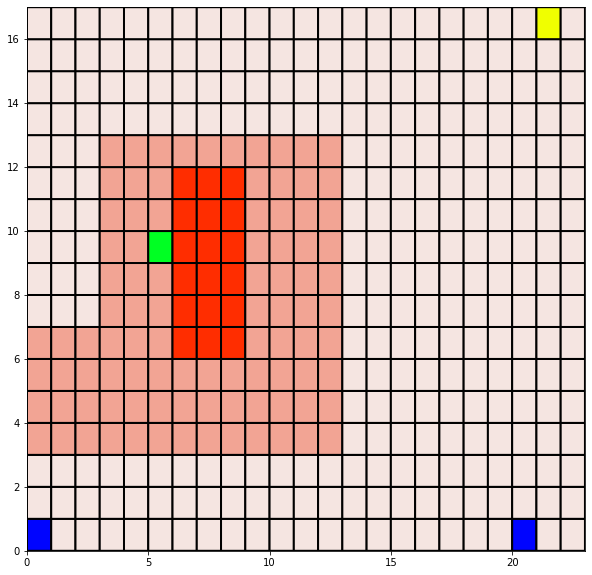

In [4]:
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

### Legend
- <span style="color:#0004FF">*Blue*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Yellow*</span> is current **state of the agent**.
- <span style="color:#FF2D00">*Redness*</span> denotes the extent of **negative reward**.

### Q values
We can use a 3D array to represent Q values. The first two indices are X, Y coordinates and last index is the action.

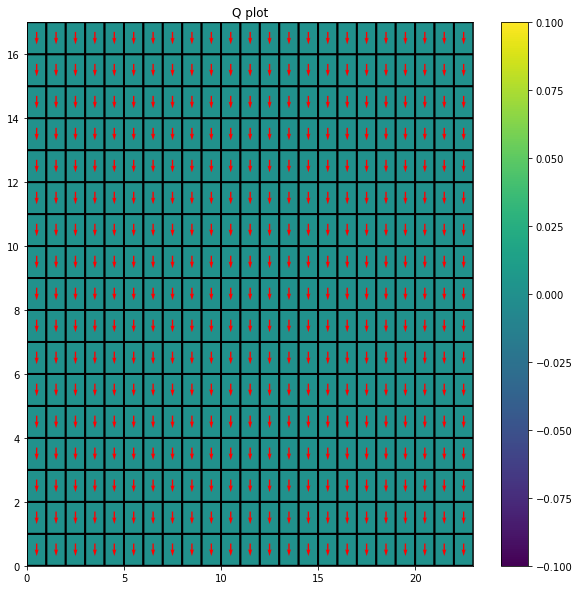

(17, 23, 4)

In [5]:
from grid_world import plot_Q

Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

plot_Q(Q)

Q.shape

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [6]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon=0.1, rg=rg):
    if not Q[state[0], state[1]].any() or rg.uniform(0, 1) < epsilon: # TODO: eps greedy condition
        return rg.choice(len(Q[state[0], state[1]])) # TODO: return random action
    else:
        return np.argmax(Q[state[0], state[1]]) # TODO: return best action

# Softmax
def choose_action_softmax(Q, state, rg=rg):
    return rg.choice(len(Q[state[0], state[1]]), p=softmax(Q[state[0], state[1]])) # TODO: return random action with selection probability

## SARSA
Now we implement the SARSA algorithm.

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [7]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

Let's implement SARSA

In [8]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)
            
            # TODO: update equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

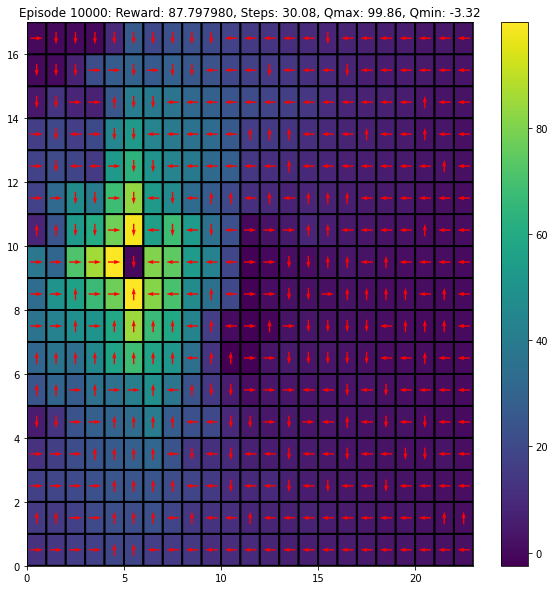

100%|██████████| 10000/10000 [00:30<00:00, 326.06it/s]


In [30]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_epsilon)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

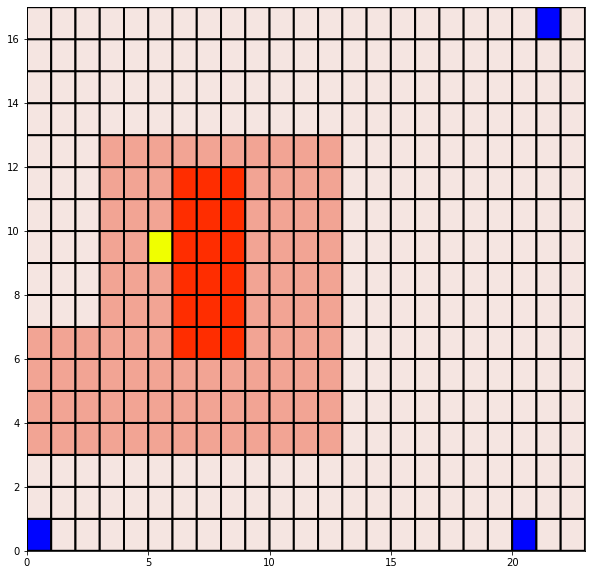

Steps: 23, Total Reward: 81


In [31]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze the policies:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

#### $\epsilon$-greedy exploration in SARSA

In [11]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)

    # TODO: run sarsa, store metrics
    Q, episode_rewards, steps_to_completion = sarsa(env, Q, choose_action = choose_action_epsilon)

    steps_avgs.append(steps_to_completion)
    reward_avgs.append(episode_rewards)

steps_avgs, reward_avgs = np.mean(np.vstack(steps_avgs), axis=0), np.mean(np.vstack(reward_avgs), axis=0)

Experiment: 1


100%|██████████| 10000/10000 [23:57<00:00,  6.95it/s]


Experiment: 2


100%|██████████| 10000/10000 [28:50<00:00,  5.78it/s]


Experiment: 3


100%|██████████| 10000/10000 [27:19<00:00,  6.10it/s]


Experiment: 4


100%|██████████| 10000/10000 [28:09<00:00,  5.92it/s]


Experiment: 5


100%|██████████| 10000/10000 [24:48<00:00,  6.72it/s]


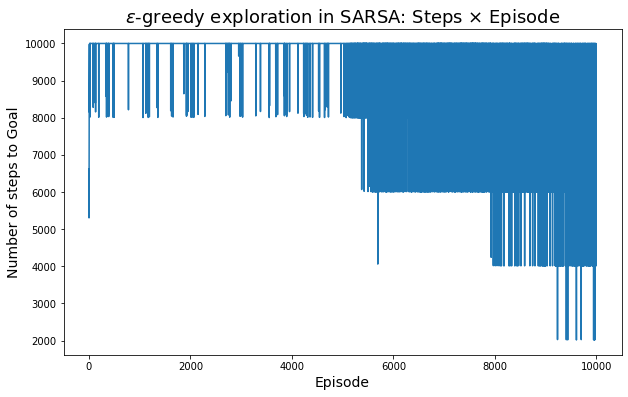

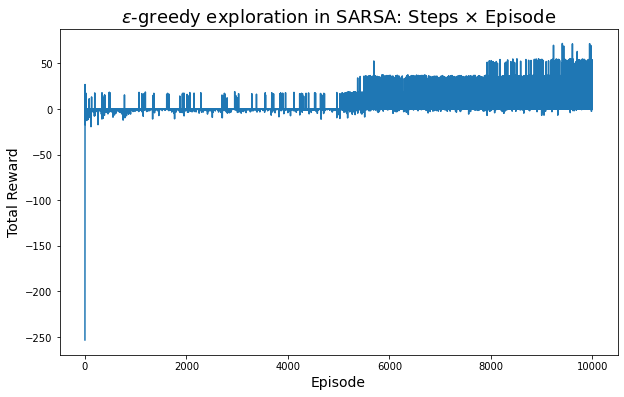

In [12]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), steps_avgs)
plt.title(r'$\epsilon$-greedy exploration in SARSA: Steps $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Number of steps to Goal', fontsize=14)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), reward_avgs)
plt.title(r'$\epsilon$-greedy exploration in SARSA: Steps $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Total Reward', fontsize=14)
plt.show()

#### Softmax policy exploration in SARSA

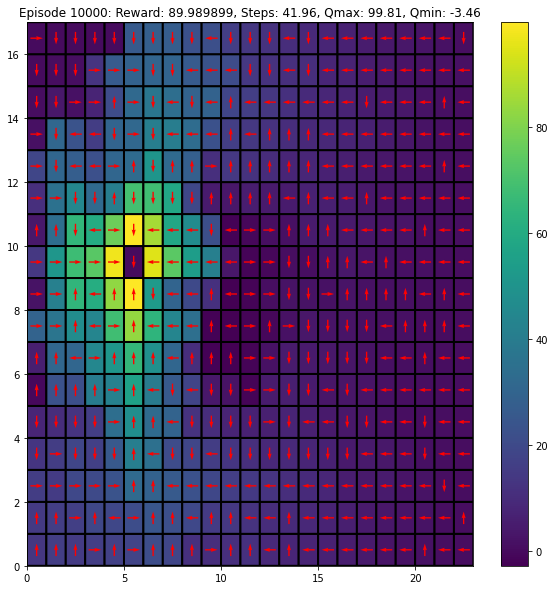

100%|██████████| 10000/10000 [00:48<00:00, 205.96it/s]


In [26]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

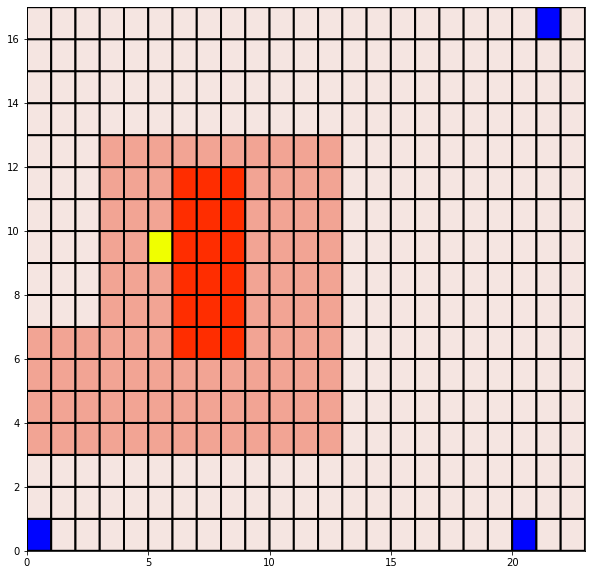

Steps: 14, Total Reward: 94


In [27]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

In [13]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)

    # TODO: run sarsa, store metrics
    Q, episode_rewards, steps_to_completion = sarsa(env, Q, choose_action = choose_action_softmax)

    steps_avgs.append(steps_to_completion)
    reward_avgs.append(episode_rewards)

steps_avgs, reward_avgs = np.mean(np.vstack(steps_avgs), axis=0), np.mean(np.vstack(reward_avgs), axis=0)

Experiment: 1


100%|██████████| 10000/10000 [00:28<00:00, 345.60it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:41<00:00, 239.14it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:36<00:00, 270.76it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:33<00:00, 302.17it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:30<00:00, 332.44it/s]


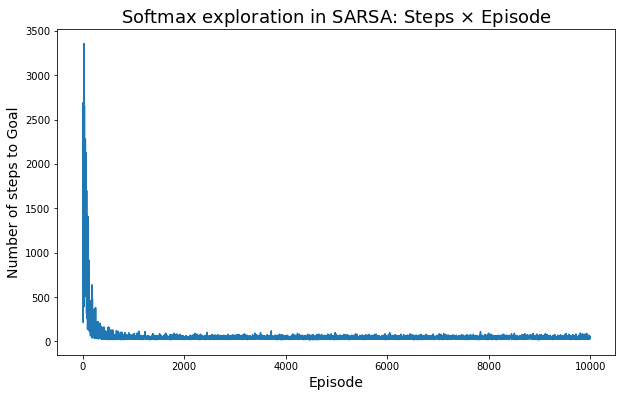

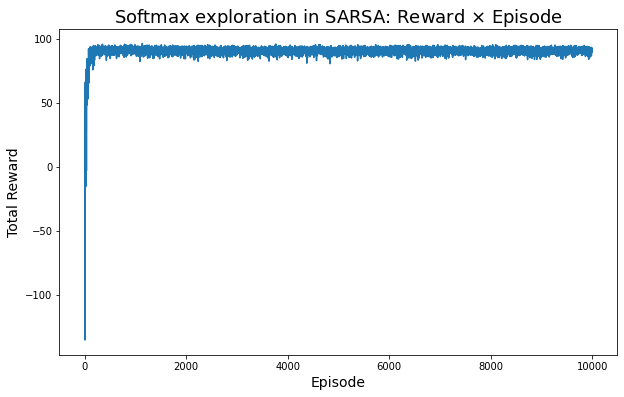

In [14]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), steps_avgs)
plt.title(r'Softmax exploration in SARSA: Steps $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Number of steps to Goal', fontsize=14)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), reward_avgs)
plt.title(r'Softmax exploration in SARSA: Reward $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Total Reward', fontsize=14)
plt.show()

## Q-Learning
Now, implement the Q-Learning algorithm as an exercise.

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

Visualize and compare results with SARSA.

In [15]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

In [16]:
print_freq = 100

def qlearning(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)
            
            # TODO: update equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1]]) - Q[state[0], state[1], action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

#### $\epsilon$-greedy exploration in Q-Learning

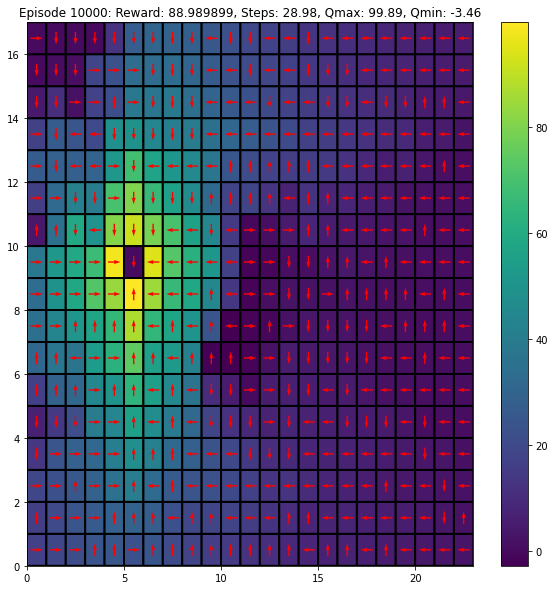

100%|██████████| 10000/10000 [00:33<00:00, 298.64it/s]


In [28]:
Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_epsilon)

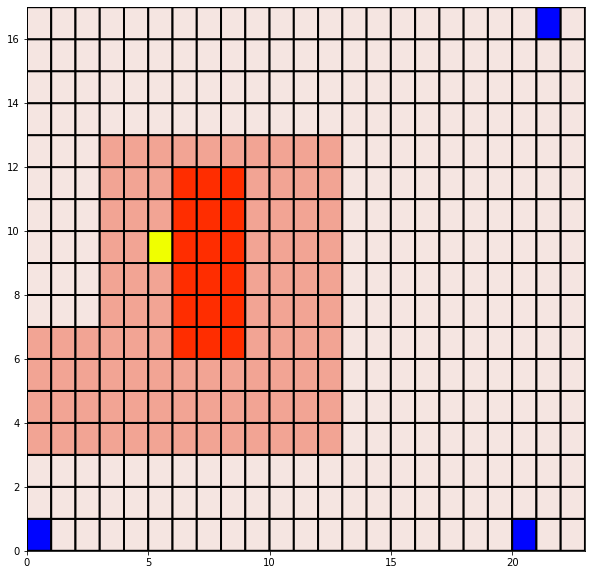

Steps: 30, Total Reward: 86


In [29]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

In [19]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)

    # TODO: run qlearning, store metrics
    Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action = choose_action_epsilon)

    steps_avgs.append(steps_to_completion)
    reward_avgs.append(episode_rewards)

steps_avgs, reward_avgs = np.mean(np.vstack(steps_avgs), axis=0), np.mean(np.vstack(reward_avgs), axis=0)

Experiment: 1


100%|██████████| 10000/10000 [33:25<00:00,  4.99it/s]


Experiment: 2


100%|██████████| 10000/10000 [37:39<00:00,  4.43it/s]


Experiment: 3


100%|██████████| 10000/10000 [30:49<00:00,  5.41it/s]


Experiment: 4


100%|██████████| 10000/10000 [33:46<00:00,  4.93it/s]


Experiment: 5


100%|██████████| 10000/10000 [34:57<00:00,  4.77it/s]


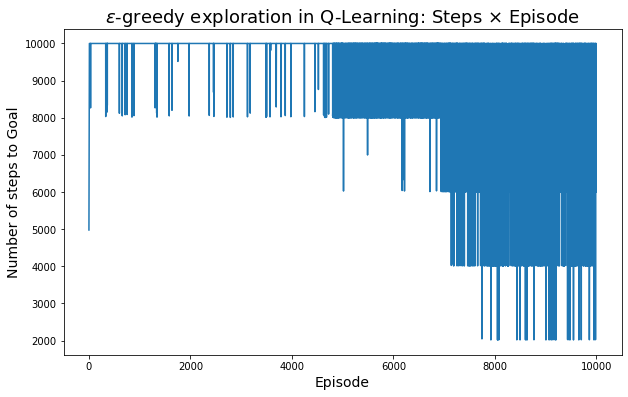

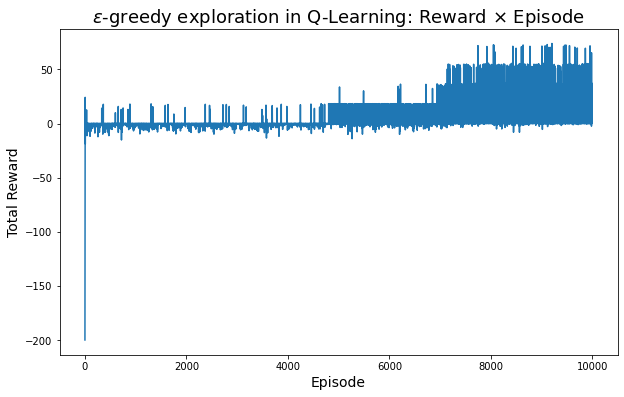

In [20]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), steps_avgs)
plt.title(r'$\epsilon$-greedy exploration in Q-Learning: Steps $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Number of steps to Goal', fontsize=14)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), reward_avgs)
plt.title(r'$\epsilon$-greedy exploration in Q-Learning: Reward $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Total Reward', fontsize=14)
plt.show()

#### Softmax policy exploration in Q-Learning

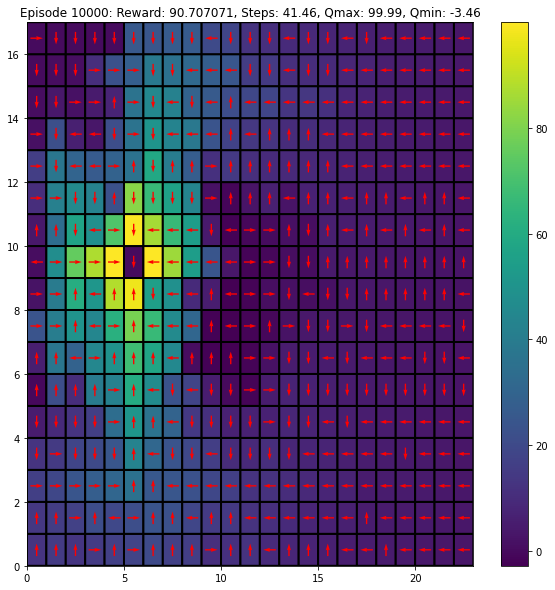

100%|██████████| 10000/10000 [00:55<00:00, 180.84it/s]


In [25]:
Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

In [21]:
num_expts = 5
reward_avgs, steps_avgs = [], []

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)

    # TODO: run qlearning, store metrics
    Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action = choose_action_softmax)

    steps_avgs.append(steps_to_completion)
    reward_avgs.append(episode_rewards)

steps_avgs, reward_avgs = np.mean(np.vstack(steps_avgs), axis=0), np.mean(np.vstack(reward_avgs), axis=0)

Experiment: 1


100%|██████████| 10000/10000 [00:40<00:00, 249.71it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:32<00:00, 303.13it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:34<00:00, 289.89it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:39<00:00, 252.87it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:33<00:00, 296.80it/s]


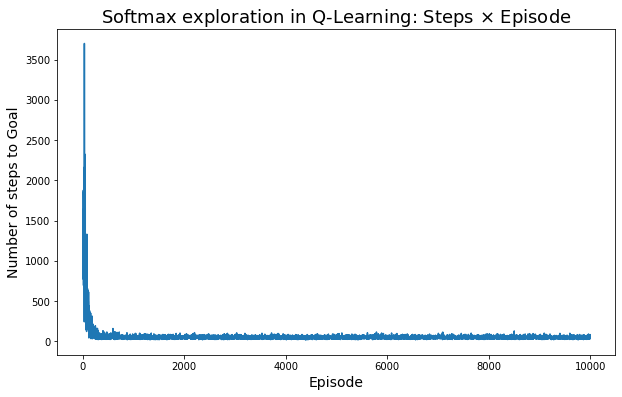

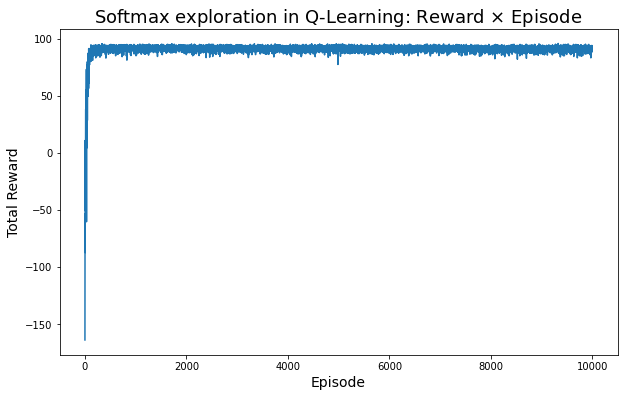

In [22]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), steps_avgs)
plt.title(r'Softmax exploration in Q-Learning: Steps $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Number of steps to Goal', fontsize=14)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(episodes), reward_avgs)
plt.title(r'Softmax exploration in Q-Learning: Reward $\times$ Episode', fontsize=18)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Total Reward', fontsize=14)
plt.show()

### TODO: What differences do you observe between the policies learnt by Q Learning and SARSA (if any). 

\<Write answer here\>
## Comparison of Exploration Strategies in SARSA and Q-learning

### Softmax in SARSA:

- **Exploration Strategy:** SARSA with softmax exploration assigns probabilities to each action based on their Q-values. The softmax function introduces a level of stochasticity, allowing for a more varied exploration approach.
  
- **Stochasticity:** The softmax strategy inherently leads to a more probabilistic policy, making it suitable for scenarios where a more varied exploration is desired. It can be seen that averaging over just 5 simulations and with 1e5 epochs, the agent has been able to learn the game properly and the total reward is nearly 100 with the number of steps close to 30 for episodes over 200.

### Epsilon-Greedy in SARSA:

- **Exploration Strategy:** SARSA with epsilon-greedy exploration selects the action with the highest Q-value with probability $1-\epsilon$, and with probability $\epsilon$, it selects a random action. This introduces a level of randomness into the action selection process.

- **Stochasticity:** While primarily exploiting the best action, epsilon-greedy ensures occasional exploration, making it a more deterministic approach compared to softmax. It can been seen from the graphs that it performs poorly on average as compared to softmax, as the $\epsilon$-greedy gives more priorities to instantenous best action most of the times having a lesser rewards on long run. As number of episodes increased, the reward tends to go closer to 50 but with an average number of steps of 2000. Also, there is a drastic difference between the training time of \(epsilon\)-greedy, nearly 130 minutes, as compared to just 3 minutes in softmax.

### Softmax in Q-learning:

- **Exploration Strategy:** Q-learning with softmax exploration assigns probabilities to each action based on their Q-values. This introduces a stochastic element into the action selection process, encouraging exploration.

- **Stochasticity:** Similar to softmax in SARSA, the softmax strategy in Q-learning results in a more probabilistic policy, suitable for scenarios where exploration is crucial. Similar to SARSA, it performs much better than \(epsilon\)-greedy and the results are quite analogous to that of SARSA.

### Epsilon-Greedy in Q-learning:

- **Exploration Strategy:** Q-learning with epsilon-greedy exploration selects the action with the highest Q-value with probability $1-\epsilon$, and with probability $\epsilon$, it selects a random action. This ensures a balance between exploiting the best-known actions and exploring new ones.

- **Stochasticity:** While primarily exploiting the best action, $\epsilon$-greedy introduces randomness, making it more deterministic than softmax but still allowing for exploration. Again, it can been seen from the graphs that it performs poorly on average as compared to softmax, as the $\epsilon$-greedy gives more priorities to instantenous best action most of the times having a lesser rewards on long run. As number of episodes increased, the reward tends to go closer to 75 but with an average number of steps of 2000. Also, there is a drastic difference between the training time of $\epsilon$-greedy, nearly 170 minutes, as compared to just 3 minutes in softmax.

#### Main Differences:

- **Stochasticity:** Softmax strategies result in more stochastic policies, introducing a level of randomness in action selection, but averaged over multiple simulation, it tends to perform much faster and better. Epsilon-greedy strategies, while still introducing exploration, are less stochastic and tend to favor exploitation, thus, are significantly slower and most of the time generates poor results as it tends to focus more on instantenous reward, which, in turn, sometimes gives less overall reward in long run. 

- **Exploration-Exploitation Tradeoff:** Epsilon-greedy strategies explicitly balance exploration and exploitation by designating a probability for random actions. Softmax strategies also balance exploration but do so by considering the probabilities associated with each action based on Q-values.

- **Suitability:** Softmax is clearly more suitable as a diverse exploration strategy is desired, while epsilon-greedy may be preferred in some situation for a more controlled form of exploration.

- **SARSA $\times$ Q-learning:** SARSA, as an on-policy method, updates its Q-values based on the current policy's action. The temporal difference target in SARSA involves the Q-value of the next state and the action selected according to the current policy. SARSA takes into account the action actually taken in the environment under the current policy when updating its Q-values. On the other hand, Q-learning, being an off-policy method, updates its Q-values by considering the maximum Q-value of the next state irrespective of the action taken. Q-learning does not necessarily consider the action taken in the environment but focuses on the best possible action in the next state. This difference in the temporal difference target reflects the distinction between on-policy and off-policy learning. SARSA updates its Q-values based on the actions it takes, whereas Q-learning updates its Q-values based on the best possible actions in the next state, regardless of the action taken. This distinction influences their learning dynamics and the policies they converge to. However, here both performed very similarly using softmax policy.


In [23]:
# !pip install nbconvert
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [24]:
# !jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/CS6700_Tutorial_4_QLearning_SARSA_ROLLNUMBER.ipynb"